# Univariate Sort
1. Load the monthly CRSP file, the Fama-French Factors, and the estimated betas from the tidy_finance_*.sqlite database.

2. Create portfolio sorts based on the lagged beta. Specifically, you compute the breakpoint as the median lag beta each month. Then, you compute the returns of a portfolio that invests only in the stocks with a higher beta than the breakpoint and a portfolio that invests only in the stocks with a lower beta than the breakpoints. The portfolio weights can either be equal or value-weighted.

3. What are the monthly excess returns of both portfolios?

4. Does a portfolio that goes long high beta stocks and short low beta stocks yield an excess return significantly different from zero?

5. Write a general function for portfolio sorts based on a variable number of breakpoints. Then, compute portfolio returns based on lagged beta decile sorts.

6. What is the CAPM alpha of the ten portfolio returns? Is this finding in line with your expectations based on the CAPM implications?

7. Does a high beta minus low beta portfolio yield abnormal excess returns?

In [1]:
import pandas as pd, numpy as np
import sqlite3
from plotnine import *
tidy_finance_python = sqlite3.connect( database="/Users/asbjornfyhn/Desktop/Emp Fin/data/tidy_finance_python.sqlite")
pd.read_sql_query('''SELECT name FROM sqlite_schema WHERE type ='table' AND  name NOT LIKE 'sqlite_%';''', con =tidy_finance_python)

,name
0,trace_enhanced
1,crsp_daily
2,factors_ff3_monthly
3,factors_ff5_monthly
4,factors_ff3_daily
5,industries_ff_monthly
6,factors_q_monthly
7,macro_predictors
8,cpi_monthly
9,fisd


### 1. Part
**Load the monthly CRSP file, the Fama-French Factors, and the estimated betas from the tidy_finance_*.sqlite database.**

Check all columns for all three tables 

In [2]:
print(pd.read_sql_query('''SELECT * FROM crsp_monthly limit 1 ;''', con =tidy_finance_python).columns)
print(pd.read_sql_query('''SELECT * FROM factors_ff3_monthly limit 1 ;''', con =tidy_finance_python).columns)
print(pd.read_sql_query('''SELECT * FROM beta limit 1 ;''', con =tidy_finance_python).columns)

Index(['permno', 'date', 'month', 'ret', 'shrout', 'altprc', 'exchcd', 'siccd',
       'mktcap', 'mktcap_lag', 'exchange', 'industry', 'ret_excess', 'gvkey'],
      dtype='object')
Index(['month', 'mkt_excess', 'smb', 'hml', 'rf'], dtype='object')
Index(['permno', 'month', 'beta_monthly', 'beta_daily'], dtype='object')


Read data from allt three tables in the database

In [3]:
crps_monthly = (pd.read_sql_query('select * from crsp_monthly;',con=tidy_finance_python, parse_dates={"month"}))
ff3_monthly = (pd.read_sql_query('select * from factors_ff3_monthly;',con=tidy_finance_python, parse_dates={"month"}))
beta_monthly = (pd.read_sql_query('select * from beta;',con=tidy_finance_python, parse_dates={"month"}))


Merge crps_monthly and beta_monthly on permno (company specific) and month (date). Then merge the result with fama_french_monthly on date.

In [4]:
# merge crsp and beta on month and permno
df = pd.merge(crps_monthly, beta_monthly, on=["month",'permno'],how='left')
# merge with ff3 factors on month
df = pd.merge(df, ff3_monthly, on=["month"],how='left')
# drop rows where beta is missing values -- before 1964 
df.dropna(subset=['beta_monthly'], inplace=True)
# sort by month and permno
df = df.sort_values(by=['month','permno']).reset_index(drop=True)

In [69]:
print(df[['month','permno','ret','beta_monthly']].iloc[:10,:])

       month  permno       ret  beta_monthly
0 1965-01-01   10006  0.053459      1.160281
1 1965-01-01   10014  0.050000      0.961043
2 1965-01-01   10030  0.048421      0.556079
3 1965-01-01   10057  0.039855      1.259991
4 1965-01-01   10102  0.090487      0.983166
5 1965-01-01   10137  0.039823      0.795975
6 1965-01-01   10145  0.104116      1.001015
7 1965-01-01   10153  0.150943      1.303733
8 1965-01-01   10161  0.055394      1.067752
9 1965-01-01   10188  0.055118      1.497323


### 2. Part
**Create portfolio sorts based on the lagged beta. Specifically, you compute the breakpoint as the median lag beta each month. Then, you compute the returns of a portfolio that invests only in the stocks with a higher beta than the breakpoint and a portfolio that invests only in the stocks with a lower beta than the breakpoints. The portfolio weights can either be equal or value-weighted.**

*First of we lag the monthly beta estimates by 1 month.*

*Next, we calculate the median beta and use it as a breaking point.*

*Lastly, we create two portfolios with equal weigths: one with all the companies with a beta below the median and one with betas above the median*

In [70]:
# lag the beta by one month
df['beta_monthly'] = df.groupby('permno')['beta_monthly'].shift(1)
# calculate median of beta for each month
beta_median = df.groupby('month')['beta_monthly'].median()
# create a new column that indicates if the beta is above the median
df['beta_above_median'] = df['beta_monthly'] > df['month'].map(beta_median)
# for each month calculate the portfolio weight as equal weighted only for the stocks with beta above the median
df['portfolio_weight_above'] = df['beta_above_median'] / df.groupby('month')['beta_above_median'].transform('sum')
df['portfolio_weight_below'] = (1-df['beta_above_median']) / df.groupby('month')['beta_above_median'].transform('sum')

*We loop through all months in the dataframe. We check if the portfolio weights related to the month of inspection sum to 1. Then, we create the return for each portfolio and store it in the dataframe port_df*

In [71]:
# create a dataframe with 'month' as index
port_df = pd.DataFrame(index=df['month'].unique(),columns=['portfolio_return_above', 'portfolio_return_below'])

for month in df['month'].unique():
    sum_ = df[df['month'] == month]['portfolio_weight_above'].sum()
    if not np.isclose(sum_, 1):
        print(f'The sum of portfolio weights is not 1 but {sum_:0.2f} for month {month}')
    else: 
        weights_below = df.loc[df['month'] == month, 'portfolio_weight_below'].values
        weights_above = df.loc[df['month'] == month, 'portfolio_weight_above'].values
        returns = df.loc[df['month'] == month, 'ret'].values
        port_df.loc[month, 'portfolio_return_below'] = weights_below @ returns.T
        port_df.loc[month, 'portfolio_return_above'] = weights_above @ returns.T
        
        # print(f'The portfolio return for month {month} is {weights_above @ returns.T:0.2%}')


The sum of portfolio weights is not 1 but 0.00 for month 1965-01-01 00:00:00


*Transforming the dataframe to make it have the right formats etc.*
From the summary statistics, we see that the mean for the portoflio

In [76]:
port_df = (port_df
           .reset_index(drop=False)
           .rename(columns={'index':'month'})
           .assign(month = lambda x: pd.to_datetime(x['month']))
           .sort_values(by='month')
           .set_index('month')
           .assign(portfolio_return_above = lambda x: x['portfolio_return_above'].astype(float),
                     portfolio_return_below = lambda x: x['portfolio_return_below'].astype(float))
           )
print(port_df.describe())

       portfolio_return_above  portfolio_return_below
count              695.000000              695.000000
mean                 0.012818                0.012805
std                  0.070913                0.045342
min                 -0.306963               -0.230759
25%                 -0.026485               -0.010289
50%                  0.012967                0.015673
75%                  0.052276                0.037652
max                  0.350698                0.259637


,month,portfolio,return
0,1965-01-01,portfolio_return_above,0.077560
1,1965-01-01,portfolio_return_below,0.041761
2,1965-02-01,portfolio_return_above,0.037143
3,1965-02-01,portfolio_return_below,0.021118
4,1965-03-01,portfolio_return_above,0.001816


       month          Portfolio    return
0 1965-02-01  Above Median Beta  0.037319
1 1965-02-01  Below Median Beta  0.021193
2 1965-03-01  Above Median Beta  0.005778
3 1965-03-01  Below Median Beta  0.002224
4 1965-04-01  Above Median Beta  0.046244


/opt/anaconda3/envs/aef/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 1 rows containing missing values.


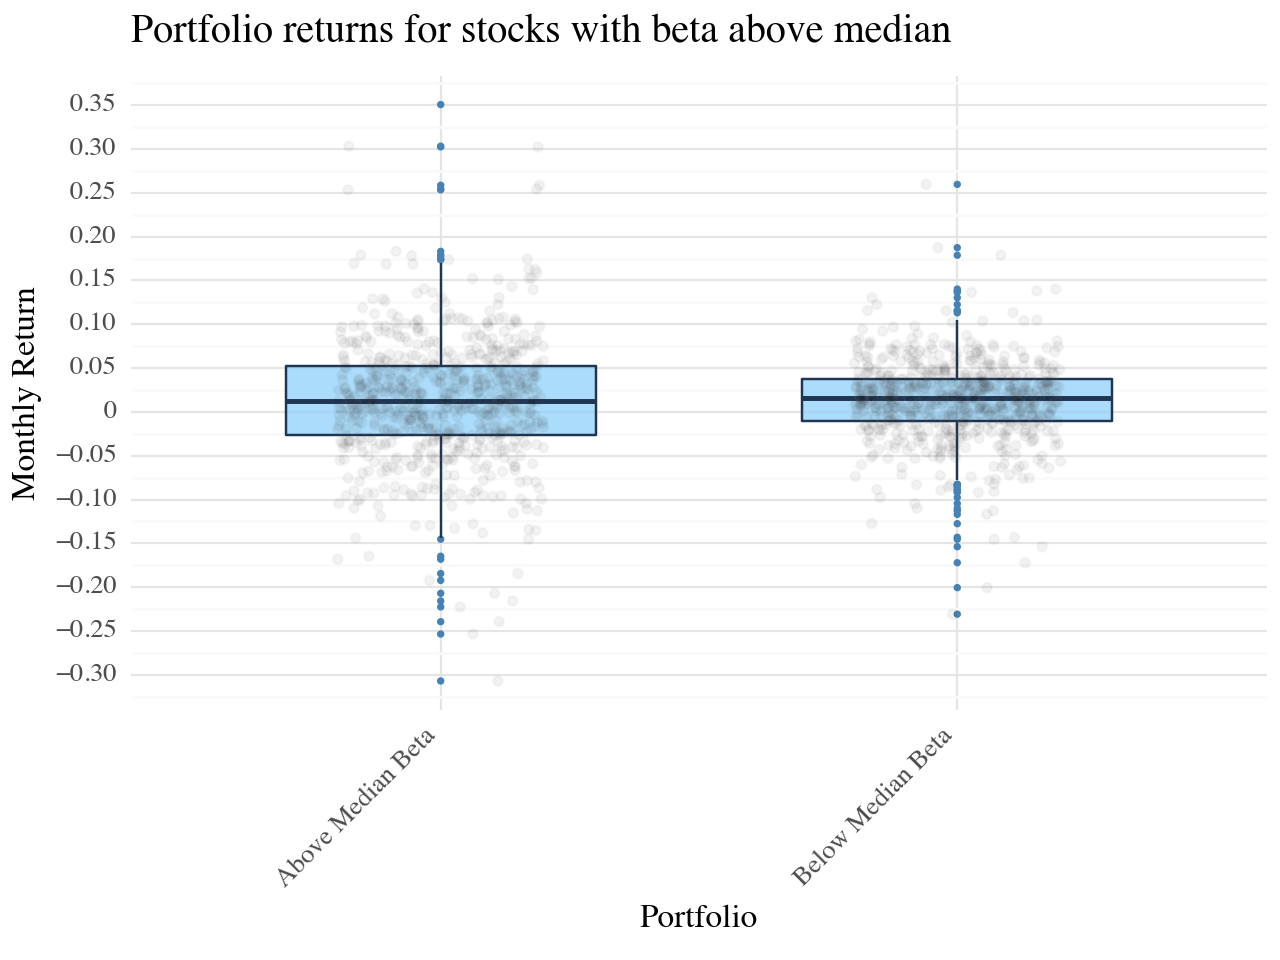

<Figure Size: (640 x 480)>

In [89]:
# stack the dataframe
port_df_stack = (port_df
                 .stack()
                 .reset_index()
                 .rename(columns={'level_1':'Portfolio',0:'return'})
                 .replace({'portfolio_return_above':'Above Median Beta',
                          'portfolio_return_below':'Below Median Beta'})
                 )
print(port_df_stack.head())
# create a boxplot of the portfolio returns
(ggplot(port_df_stack.dropna(subset=['return'])) +
    aes(y='return',x='Portfolio') +
    geom_boxplot(colour="#1F3552", 
                 fill="lightskyblue",
                 alpha=0.7, # transparency for the fill
                 outlier_shape=".", # shape of outlier
                 outlier_colour="steelblue", # colour of outlier
                 width=0.6
                 ) +
    geom_jitter(
        colour="grey",
        fill="black",
        width=.2,
        alpha=.05,
    ) + 
    theme_minimal(
        base_size=12,
        base_family='serif',
    ) + 
    # theme_bw() +  
    # + theme(
    #     axis_line=element_line(size=1, colour="black"),
    #     panel_grid_major=element_line(colour="#d3d3d3"),
    #     panel_grid_minor=element_blank(),
    #     panel_border=element_blank(),
    #     panel_background=element_blank(),
    #     plot_title=element_text(size=15, family="Tahoma", 
    #                             face="bold"),
    #     text=element_text(family="Tahoma", size=11),
    #     axis_text_x=element_text(colour="black", size=10),
    #     axis_text_y=element_text(colour="black", size=10), 
    # )
    #if prefer to create own theme
    labs(title='Portfolio returns for stocks with beta above median', x='Portfolio', y='Monthly Return') +
    scale_y_continuous(breaks=np.arange(-0.45, 0.401, 0.05), limits=[port_df_stack['return'].min(), port_df_stack['return'].max()]) +
    theme(axis_text_x=element_text(angle=45, hjust=1))
    )
